# TFM: Web Scraping 

### author: "Enrique Calleja Hoyos"
### date: "14/10/2020"

En este notebook haremos scraping sobre el sitio web https://coinmarketcap.com/ para obtener el histórico de precios de ciertas criptomonedas ya que la API gratuita no permite obtener el histórico.

In [2]:
#Instalamos la libreria
#!pip install beautifulsoup4

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import time

Echamos un vistazo a la estructura de la página principal de https://coinmarketcap.com/ 

In [3]:
cmc=requests.get('https://coinmarketcap.com/')
soup=BeautifulSoup(cmc.content,'html.parser')

Veamos el aspecto que tiene la página:

In [16]:
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
  <link crossorigin="anonymous" href="https://s2.coinmarketcap.com" rel="preconnect"/>
  <link href="//www.googletagmanager.com" rel="preconnect"/>
  <link as="style" href="https://files.coinmarketcap.com/static/header_banner/header-banner-production.css" rel="preload"/>
  <meta content="EDc1reqlQ-zAgeRrrgAxRXNK-Zs9JgpE9a0wdaoSO9A" name="google-site-verification"/>
  <meta content="https://s2.coinmarketcap.com/static/cloud/img/splash_600x315_1.png?_=38a265f" property="og:image"/>
  <meta content="image/png" property="og:image:type"/>
  <meta content="600" property="og:image:width"/>
  <meta content="315" property="og:image:height"/>
  <meta content="CoinMarketCap" property="og:site_name"/>
  <meta content="website" property="og:type"/>
  <meta content="summary_large_image" na

A partir de la página principal, extraeremos los ids de todas las criptomonedas, ya que los necesitaremos más adelante para  recuperar el histórico de precios.

In [4]:
data=soup.find('script',id="__NEXT_DATA__",type="application/json")
coins={}

coin_data=json.loads(data.contents[0])
listings=coin_data['props']['initialState']['cryptocurrency']['listingLatest']['data']

for i in listings:
    coins[str(i['id'])]=i['slug']
coins

{'1': 'bitcoin',
 '1027': 'ethereum',
 '825': 'tether',
 '52': 'xrp',
 '1831': 'bitcoin-cash',
 '1839': 'binance-coin',
 '1975': 'chainlink',
 '6636': 'polkadot-new',
 '2010': 'cardano',
 '2': 'litecoin',
 '3602': 'bitcoin-sv',
 '3635': 'crypto-com-coin',
 '3408': 'usd-coin',
 '1765': 'eos',
 '328': 'monero',
 '1958': 'tron',
 '2011': 'tezos',
 '512': 'stellar',
 '1376': 'neo',
 '3794': 'cosmos',
 '3957': 'unus-sed-leo',
 '3717': 'wrapped-bitcoin',
 '873': 'nem',
 '2502': 'huobi-token',
 '4943': 'multi-collateral-dai',
 '1720': 'iota',
 '4687': 'binance-usd',
 '2416': 'theta',
 '1437': 'zcash',
 '3077': 'vechain',
 '2239': 'aave',
 '131': 'dash',
 '1321': 'ethereum-classic',
 '1518': 'maker',
 '5617': 'uma',
 '1808': 'omg',
 '2586': 'synthetix-network-token',
 '5864': 'yearn-finance',
 '2566': 'ontology',
 '3897': 'okb',
 '4030': 'algorand',
 '2563': 'trueusd',
 '4195': 'ftx-token',
 '7083': 'uniswap',
 '3718': 'bittorrent',
 '74': 'dogecoin',
 '109': 'digibyte',
 '1697': 'basic-attent

Sobre el listado anterior, nos quedaremos unicamente con las 5 criptomonedas que nos interesan:

In [5]:
coins_5=dict(filter(lambda x:x[1] in ['bitcoin','xrp','litecoin','stellar','tether'],coins.items()))
coins_5

{'1': 'bitcoin',
 '825': 'tether',
 '52': 'xrp',
 '2': 'litecoin',
 '512': 'stellar'}

## Extracción de los datos históricos OHCLV
Veamos que pinta tiene la página donde aparecen los datos históricos

In [40]:
page=requests.get(f'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20200101&end=20200130')
soup=BeautifulSoup(page.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
  <link crossorigin="anonymous" href="https://s2.coinmarketcap.com" rel="preconnect"/>
  <link href="//www.googletagmanager.com" rel="preconnect"/>
  <link as="style" href="https://files.coinmarketcap.com/static/header_banner/header-banner-production.css" rel="preload"/>
  <meta content="EDc1reqlQ-zAgeRrrgAxRXNK-Zs9JgpE9a0wdaoSO9A" name="google-site-verification"/>
  <meta content="CoinMarketCap" property="og:site_name"/>
  <meta content="website" property="og:type"/>
  <meta content="summary_large_image" name="twitter:card"/>
  <meta content="app-id=1282107098" name="apple-itunes-app"/>
  <link href="/apple-touch-icon.png" rel="apple-touch-icon"/>
  <link href="/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/manifest.json" rel="manifest"/>
  <script>
 

Ahora extraeremos los datos para cada una de las criptomonedas que están en nuestra lista

In [6]:
close=[]
timestamp=[]
slug=[]

for i in coins_5:
    #indicamos un día menos en la fecha fin porque nos trae un día de mas
    page=requests.get(f'https://coinmarketcap.com/currencies/{coins_5[i]}/historical-data/?start=20150101&end=20191203')
    soup=BeautifulSoup(page.content, 'html.parser')
    data=soup.find('script',id="__NEXT_DATA__",type="application/json")
    historical_data=json.loads(data.contents[0])
    quotes=historical_data['props']['initialState']['cryptocurrency']['ohlcvHistorical'][i]['quotes']
    for j in quotes:
        close.append(j['quote']['USD']['close'])
        timestamp.append(j['quote']['USD']['timestamp'])
        slug.append(coins_5[i])

#Construimos el dataframe con la información recuperada
df=pd.DataFrame(columns=['slug','close','timestamp'])
df['close']=close
df['timestamp']=timestamp
df['slug']=slug
df.head()
#df.to_csv('criptoscarp.csv',index=False)

Hacemos un *spreading* para que cada moneda tenga su propia columna:

In [7]:
df_spread=df.pivot_table(index='timestamp',columns='slug', values='close').reset_index()
df_spread.head()

slug                 timestamp     bitcoin  litecoin   stellar  tether  \
0     2015-01-01T23:59:59.999Z  314.248993   2.69905  0.005493     NaN   
1     2015-01-02T23:59:59.999Z  315.032013   2.66736  0.005481     NaN   
2     2015-01-03T23:59:59.999Z  281.082001   2.13316  0.004672     NaN   
3     2015-01-04T23:59:59.999Z  264.195007   1.95668  0.004416     NaN   
4     2015-01-05T23:59:59.999Z  274.473999   2.08218  0.004947     NaN   

slug       xrp  
0     0.024390  
1     0.024318  
2     0.022106  
3     0.018928  
4     0.020316

In [8]:
df_spread.shape
#df_spread.tail()

(1799, 6)

In [9]:
df_spread.dtypes

slug
timestamp     object
bitcoin      float64
litecoin     float64
stellar      float64
tether       float64
xrp          float64
dtype: object

Cambiamos el formato de la fecha para adecuarla a nuestras necesidades:

In [28]:
df_spread['timestamp']=pd.to_datetime(df_spread['timestamp'])
df_spread['timestamp']=df_spread['timestamp'].dt.strftime('%Y-%m-%d')
#Los primeros valores del año 2015 para la criptomoneda tether eran NaNs, por lo que los excluimos del dataframe
df_spread=df_spread[(df_spread['timestamp']>='2015-03-06')]
df_spread.head()

slug   timestamp     bitcoin  litecoin   stellar  tether       xrp
64    2015-03-06  272.722992   1.89782  0.002952     1.0  0.010856
65    2015-03-07  276.260986   1.91050  0.002947     1.0  0.010535
66    2015-03-08  274.354004   1.89186  0.002958     1.0  0.009961
67    2015-03-09  289.606995   1.94428  0.002912     1.0  0.010643
68    2015-03-10  291.760010   2.00906  0.002935     1.0  0.010086

In [29]:
df_spread.shape

(1735, 6)

Una vez extraidos los datos con el histórico de precios de las criptomonedas, recuperaremos el csv con el histórico de precios para el índice CCI30, y construiremos un único dataset que tendrá tanto el histórico de precios para las criptomonedas como para el índice de mercado. Por último, daremos formato a dicho dataset para que pueda ser leido por el método correspondiente (*Single.import_returns()*)de la libreria eventstudy utilizada para llevar a cabo el estudio de eventos.

Leemos el fichero con el histórico de precios OHLCV del índice CCI30 descargado de la web https://cci30.com/

In [30]:
mk=pd.read_csv('ValoresDiariosIndex_cci30_OHLCV.csv')

Cambiamos el nombre de la columna Close, y nos quedamos unicamente con las columnas de interes, que recogen la fecha y el precio de cierre a esa fecha.

In [31]:
mk=mk.rename(columns={"Close":"CCI30"})
mk=mk[['Date','CCI30']]

Filtramos el periodo de datos para que coincida con el periodo de la serie histórica de las criptomonedas

In [33]:
mkprice=mk[(mk['Date']>='2015-03-06') & (mk['Date']<='2019-12-04')]

In [34]:
mkprice.shape

(1735, 2)

Hacemos el join entre el dataframe de criptomonedas y el del indice de mercado

In [35]:
allprices=pd.merge(df_spread,mkprice,left_on='timestamp',right_on='Date',how='inner')

In [70]:
allprices=allprices.rename(columns={"timestamp":"date"})
allprices=allprices[['date','bitcoin','tether','xrp','stellar','litecoin','CCI30']]
allprices2 = allprices.reindex(columns=['date','bitcoin','tether','xrp','stellar','litecoin','CCI30'])
allprices2=allprices.sort_values('date',ascending=False)

In [51]:
allprices2.tail()

date     bitcoin  tether       xrp   stellar  litecoin    CCI30
4  2015-03-10  291.760010     1.0  0.010086  0.002935   2.00906  76.2581
3  2015-03-09  289.606995     1.0  0.010643  0.002912   1.94428  76.3213
2  2015-03-08  274.354004     1.0  0.009961  0.002958   1.89186  72.3516
1  2015-03-07  276.260986     1.0  0.010535  0.002947   1.91050  74.1684
0  2015-03-06  272.722992     1.0  0.010856  0.002952   1.89782  73.7431

Una vez que el dataframe tiene el formato deseado, procederemos a guardarlo como csv. Este será el fichero que se utilizar en el paquete *eventstudy* para calcular las rentabilidades diarias.

In [39]:
allprices2.to_csv('prices4python2.csv',index=False)

## gráficos

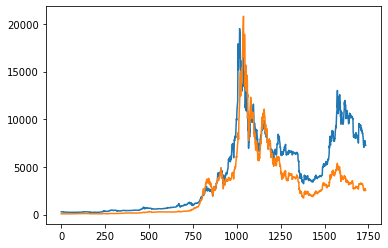

In [45]:
import matplotlib.pyplot as plt
plt.plot((allprices2['bitcoin'] ))
plt.plot((allprices2['CCI30'] ))
plt.show()

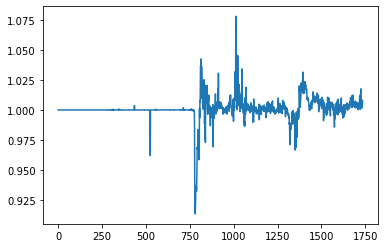

In [43]:
import matplotlib.pyplot as plt
plt.plot((allprices2['tether'] ))
plt.show()

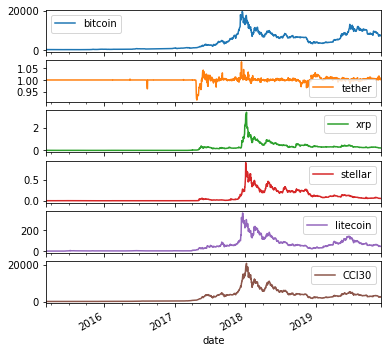

In [71]:
#df.set_index("Number")
allprices3=allprices2
allprices3['date']=pd.to_datetime(allprices3['date'])
allprices3.set_index('date',drop=True,inplace=True)
allprices3.plot(subplots=True, figsize=(6, 6));